### distribution rounds extraction

In [134]:
import pandas as pd
import os

In [135]:
# find every token allocation file
rootdir = '/Users/rxx/Documents/GitHub/tec-data-analysis/reward_vs_payouts/tec-rewards/distribution_rounds'
rewards_distrib = []

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file == 'final_praise_token_allocation.csv':
            rewards_distrib.append(os.path.join(subdir, file))

In [136]:
# concat all of the token alloc files
df = pd.concat(
    map(pd.read_csv, rewards_distrib), ignore_index=True)

In [137]:
# calculate total rewardboard payout
df1 = df[["USER ADDRESS", "TOTAL TO RECEIVE"]]
df1 = df1.loc[df["USER ADDRESS"] != "missing user address"]
df1 = df1.groupby(['USER ADDRESS']).sum()

In [162]:
# final one to look at
df_praise = df1.sort_values(by=["TOTAL TO RECEIVE"], ascending=False)

### dune data extraction

extract a query data via reverse eng of the dune api

In [139]:
import requests
import json

In [140]:
query_site = "https://dune.com/queries/1256836" 
url = "https://core-hsr.dune.com/v1/graphql"

# first query

payload = json.dumps({
  "operationName": "GetResult",
  "variables": {
    "query_id": int(query_site.split('/')[-1]),
    "parameters": [
      {
        "key": "1. Start Date",
        "type": "datetime",
        "value": "2022-01-01 00:00:00"
      },
      {
        "key": "2. End Date",
        "type": "datetime",
        "value": "2023-01-01 00:00:00"
      }
    ]
  },
  "query": "query GetResult($query_id: Int!, $parameters: [Parameter!]) {\n  get_result_v2(query_id: $query_id, parameters: $parameters) {\n    job_id\n    result_id\n    error_id\n    __typename\n  }\n}\n"
})
headers = {
  'content-type': 'application/json',
  'x-hasura-api-key': ''
}

response = requests.request("POST", url, headers=headers, data=payload)

result_id = json.loads(response.text)['data']['get_result_v2']['result_id']

In [141]:
# second query

payload = "{\"operationName\":\"FindResultDataByResult\",\"variables\":{\"result_id\":\""+result_id+"\",\"error_id\":\"00000000-0000-0000-0000-000000000000\"},\"query\":\"query FindResultDataByResult($result_id: uuid!, $error_id: uuid!) {\\n  query_results(where: {id: {_eq: $result_id}}) {\\n    id\\n    job_id\\n    runtime\\n    generated_at\\n    columns\\n    __typename\\n  }\\n  query_errors(where: {id: {_eq: $error_id}}) {\\n    id\\n    job_id\\n    runtime\\n    message\\n    metadata\\n    type\\n    generated_at\\n    __typename\\n  }\\n  get_result_by_result_id(args: {want_result_id: $result_id}) {\\n    data\\n    __typename\\n  }\\n}\\n\"}"
headers = {
  'x-hasura-api-key': '',
  'Content-Type': 'text/plain'
}

response_2 = requests.request("POST", url, headers=headers, data=payload)

json_search = json.loads(response_2.text)['data']['get_result_by_result_id']

data_dict = []

for c in json_search:
  data_dict.append(c["data"])

df2 = pd.DataFrame(data_dict)

extract only the rows which are stables (xdai, wxdai, usdc)

In [142]:
df3 = df2.loc[df2["symbol"].isin(["USDC", "xDAI", "WXDAI"])]
df3.to = df3.to.str.replace("\\", "0") # correct weird Dune address formats 
df3 = df3[["to", "amt"]]
df3 = df3.groupby(['to']).sum()

df_dune = df3.sort_values(by=["amt"], ascending=False)

C:\Users\rxx\AppData\Local\Temp\ipykernel_6276\3270325130.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df3.to = df3.to.str.replace("\\", "0") # correct weird Dune address formats
C:\Users\rxx\AppData\Local\Temp\ipykernel_6276\3270325130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.to = df3.to.str.replace("\\", "0") # correct weird Dune address formats


## correlation / visualisation

In [150]:
import matplotlib.pyplot as plt
import numpy as np

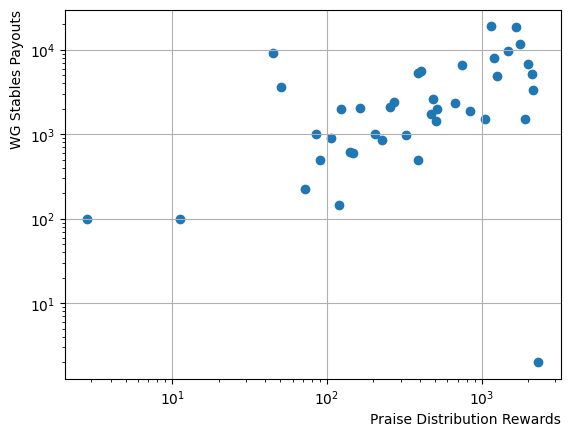

In [191]:
df4 = pd.merge(df_dune, df_praise, left_on='to',\
               right_on='USER ADDRESS', how='outer')

x = np.array(df4["TOTAL TO RECEIVE"])
y = np.array(df4["amt"])

fig, ax = plt.subplots()

ax.set_ylabel('WG Stables Payouts', loc='top')
ax.set_xlabel('Praise Distribution Rewards', loc='right')

plt.scatter(x,y)
plt.xscale('log'); plt.yscale('log')
plt.grid(True)


plt.show()

corr

In [179]:
print(np.corrcoef(x,y,"all"))

[[nan nan]
 [nan nan]]
